## Benchmark

Compares the new data processing routine against the old one. Used as a sanity check to validate the new code.

### Comparing old and new Beamforming

I never managed to get _exactly_ the same values everywhere. There are bits of old code "correcting" strange values of the raw signal before beamforming it. I never saw these strange values, so I did not implement it. Could be the root cause of it.

Also : what happens between ~500 and 540 pixels is normal : the old beamformed images were produced with a `pos_rotor = 530`, while the _actual_ data processing was done using `pos_rotor = 540`. The agreement between old and new data is a lot better if you reprocess the data with the "BF" value of `pos_rotor`. 

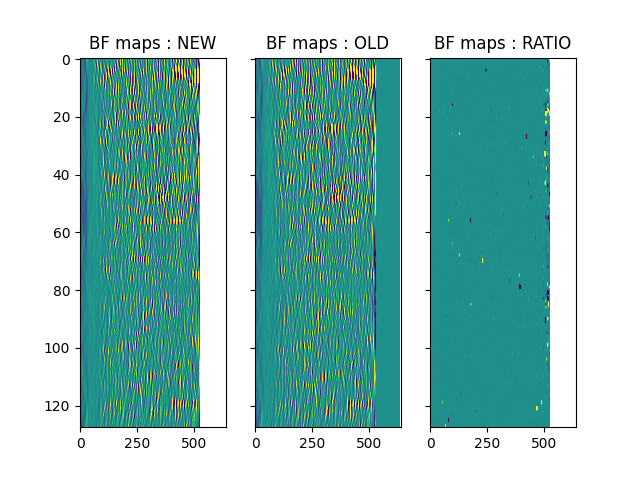

In [3]:
from functions import *
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib widget

path = 'Data/gpt_20/'

files = find_files(path,  ext='dat')
config = json.load(open(path + '/config_calcul.json'))

# Regular files
fh = open_all(files)
maps = read_map_batch(fh, n_pts=640, batch_size=130)
us = maps[128]
close_all(fh)

# New BF files
new_bf_files = find_files(path,  ext='dbf')
bfh = open_all(new_bf_files)
bf_maps_new = read_map_batch(bfh, n_pts=640, batch_size=1, mode='dbf')
close_all(bfh)

# Old BF files (could fail)
old_bf_files = find_files(path + '/Speckles/', ext='dat')
with open(old_bf_files[0], 'rb') as myfile:
    dat = np.frombuffer(myfile.read(), dtype=np.float32)
bf_map_old = dat.reshape((config['nz'],config['nx']))

# Figure generation
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True)
ax[0].imshow(bf_maps_new[0], vmin=-100, vmax=100)
ax[1].imshow(bf_map_old*4096/2, vmin=-100, vmax=100)
ax[2].imshow(bf_map_old/bf_maps_new[0]*4096/2, vmin=0.5, vmax=1.5)
# ax.imshow(bf_single)
# ax[0].plot(j0 + delays[:, j0], i0 + di, 'm')
ax[0].set_title('BF maps : NEW')
ax[1].set_title('BF maps : OLD')
ax[2].set_title('BF maps : RATIO')
ax[0].set_aspect('auto')
ax[1].set_aspect('auto')
ax[2].set_aspect('auto')
# ax.axis([0, nj, 0, ni]);

### Benchmarking the displacements 

* I use the Hilbert intensity to decide if there is enough signal, the old code uses ... the local std of the signal ?
* I use a FFT-based convolution / correlation to compute the displacement, the old code uses a (CUDA) regular correlation
* The beamformed maps were initially slightly different, so also not completely unexpected to have slightly different results

I never managed to get the results to be exactly identical but they are close enough to be usable.

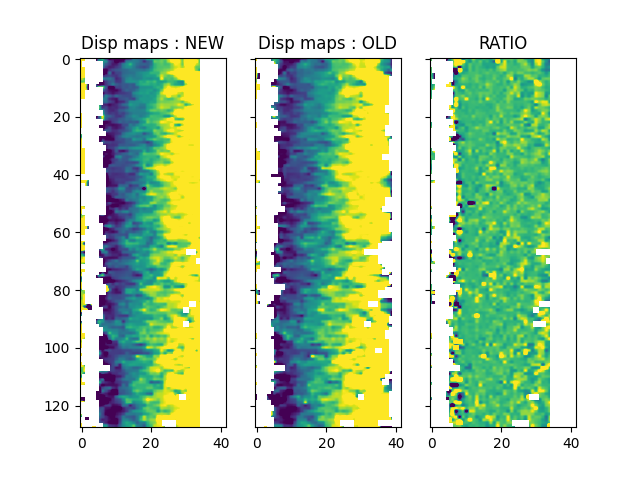

In [13]:
from functions import *
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib widget

path = 'Data/gpt_150/'

files = find_files(path,  ext='dat')
config = json.load(open(path + '/config_calcul.json'))

# Regular files
fh = open_all(files)
maps = read_map_batch(fh, n_pts=640, batch_size=130)
us = maps[128]
close_all(fh)

# New BF files
new_bf_files = find_files(path,  ext='dbf')
bfh = open_all(new_bf_files)
bf_maps_new = read_map_batch(bfh, n_pts=640, batch_size=1, mode='dbf')
close_all(bfh)

t = 10

old_dat = loadmat(path + 'Dpl.mat')
old_dpl = old_dat['Dpl']
old_dpl[old_dpl > 1e4] = np.nan
new_dat = np.load(path + '/processed.npz')
new_dpl = new_dat['disp']

%matplotlib widget
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True)
ax[0].imshow(new_dpl[:,t,:], vmin=0, vmax=1.5)
ax[1].imshow(old_dpl[:,:,t], vmin=0, vmax=1.5)
ax[2].imshow(new_dpl[:,t,:-1]/old_dpl[:,:,t], vmin=0, vmax=1.5)
ax[0].set_title('Disp maps : NEW')
ax[1].set_title('Disp maps : OLD')
ax[2].set_title('RATIO')
ax[0].set_aspect('auto')
ax[1].set_aspect('auto')
ax[2].set_aspect('auto')
# ax.axis([0, nj, 0, ni]);

### Hilbert intensity

The new signal is more "smoothed out" than the old since we are averaging it over the whole window size (usually ~40 px) instead of the stride between windows (~14 pixels), which explains the difference in sharpness between the two results. Reverting to old behaviour should be very easy (a one line change in the code). There is also a 4096 factor between the two, but this one can easily be corrected.

C:\Users\saint-michel\AppData\Local\Temp\ipykernel_15028\656286239.py:24: RuntimeWarning: divide by zero encountered in divide
  ax[2].imshow(new_hil[:,t,:-1]/old_hil[:,t,:], vmin=0.5, vmax=1.5)


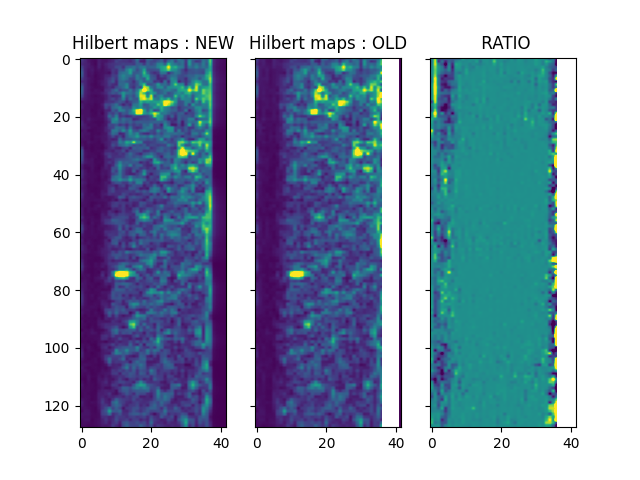

In [17]:
from functions import *
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib widget

path = 'Data/gpt_150/'

files = find_files(path,  ext='dat')
config = json.load(open(path + '/config_calcul.json'))

t = 10

old_dat = loadmat(path + 'Conc.mat')
old_hil = 4096*np.moveaxis(old_dat['Hils_moy'], [0,1,2],[2,0,1])
new_dat = np.load(path + '/processed.npz')
new_hil = new_dat['hil']

%matplotlib widget
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True)
ax[0].imshow(new_hil[:,t,:], vmin=0, vmax=300)
ax[1].imshow(old_hil[:,t,:], vmin=0, vmax=300)
ax[2].imshow(new_hil[:,t,:-1]/old_hil[:,t,:], vmin=0.5, vmax=1.5)
ax[0].set_title('Hilbert maps : NEW')
ax[1].set_title('Hilbert maps : OLD')
ax[2].set_title(' RATIO')

ax[0].set_aspect('auto')
ax[1].set_aspect('auto')
ax[2].set_aspect('auto')
# ax.axis([0, nj, 0, ni]);

In [16]:
new_hil

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

### Displacement plot

Old vs. new velocity profile. Somehow the old profile is shifted and dilated compare to the new one, but the overall aspect is very similar. These things can be corrected in the calibration.

C:\Users\saint-michel\AppData\Local\Temp\ipykernel_6204\2625367147.py:1: RuntimeWarning: Mean of empty slice
  old_dpl_profile = np.nanmean(np.nanmean(old_dpl, axis=0), axis=-1)
C:\Users\saint-michel\AppData\Local\Temp\ipykernel_6204\2625367147.py:2: RuntimeWarning: Mean of empty slice
  new_dpl_profile = np.nanmean(np.nanmean(new_dpl, axis=0), axis=+0)


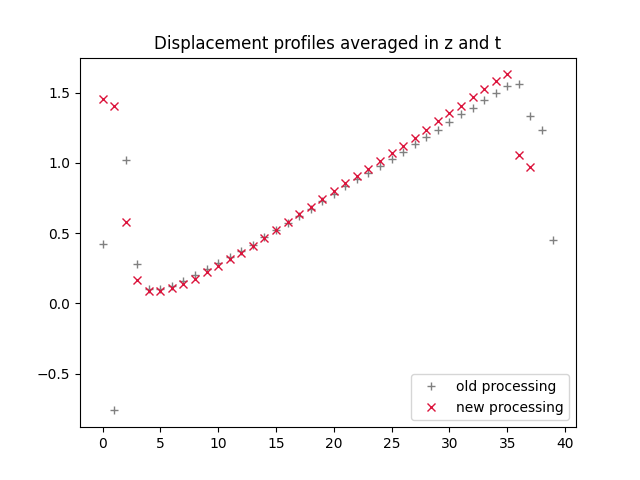

In [6]:
old_dpl_profile = np.nanmean(np.nanmean(old_dpl, axis=0), axis=-1)
new_dpl_profile = np.nanmean(np.nanmean(new_dpl, axis=0), axis=+0)

fig, ax = plt.subplots()
ax.plot(old_dpl_profile, '+', color='gray', label='old processing')
ax.plot(new_dpl_profile, 'x', color='crimson', label='new processing')
ax.set_title('Displacement profiles averaged in z and t')
ax.legend()